In [1]:
#set working directory 
import os
os.chdir("/Users/coralflanagan1/Desktop/courses/Gannon-DS/data-presentation-cjf215")
current_directory = os.getcwd() 
print(f"Current working directory: {current_directory}")

Current working directory: /Users/coralflanagan1/Desktop/courses/Gannon-DS/data-presentation-cjf215


In [2]:
###load dataframes 

#load the pandas library
import pandas as pd

#import IPEDS data 
ipeds = pd.read_csv('ipeds.csv')
ipeds.head()

#import PEPS data
peps = pd.read_csv('peps.csv')
peps.head()

,unitid,instnm_peps,instnm_ipeds,address1,city,stabbr,zip,long,lat
0,100654,Alabama Agricultural & Mechanical University,Alabama A & M University,4900 Meridian Street,Normal,AL,35762,-86.572290,34.783790
1,101514,Calhoun Community College,John C Calhoun State Community College,6250 Highway 31 North,Tanner,AL,35671,-86.950392,34.647112
2,101286,George C. Wallace Community College,George C Wallace Community College-Dothan,1141 Wallace Drive,Dothan,AL,36303,-85.468213,31.315357
3,100751,University of Alabama,The University of Alabama,801 University Boulevard,Tuscaloosa,AL,35487,-87.547466,33.208951
4,104425,Cochise College,Cochise County Community College District,901 North Colombo,Sierra Vista,AZ,85635,-110.246900,31.563383


In [220]:
###Analysis Slide 1-Table, Counts of Institutions in Each Dataset

#extract count of institutions in each dataset and in TN specifically 
tot_peps = len(peps)  
tot_peps_tn = len(peps[peps['stabbr'] == 'TN'])

tot_ipeds = len(ipeds)
tot_ipeds_tn = len(ipeds[ipeds['stabbr'] == 'TN'])

#Create a table
summary_df = pd.DataFrame({
    'Dataset': ['peps', 'ipeds'],
    'Total Observations': [tot_peps, tot_ipeds],
    'Total Observations in TN': [tot_peps_tn, tot_ipeds_tn]
})

print(summary_df)

#Output table to excel format 
output_excel_path = 'summary_stats_table.xlsx'
summary_df.to_excel(output_excel_path, index=False)
print(f"Summary table has been saved to {output_excel_path}")


  Dataset  Total Observations  Total Observations in TN
0    peps                7015                       235
1   ipeds                1755                        49
Summary table has been saved to summary_stats_table.xlsx


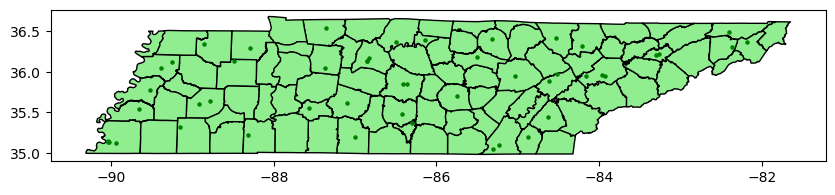

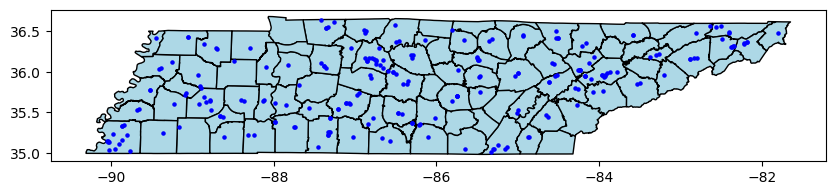

In [229]:
###Analysis Slide 2-Map of institution locations using IPEDs versus using PEPS

#Import packages for spatial data 
import numpy as np
import matplotlib.pyplot as plt

import geopandas as gpd
from geopandas import GeoSeries, GeoDataFrame

#Limit to TN only 
ipeds = ipeds[ipeds['stabbr'] == 'TN']
peps = peps[peps['stabbr'] == 'TN']

#convert to geo dataframes
g_ipeds=GeoDataFrame(ipeds, geometry=gpd.points_from_xy(ipeds['longitud'], ipeds['latitude']))
g_peps=GeoDataFrame(peps, geometry=gpd.points_from_xy(peps['long'], peps['lat']))

#load shapefile for US 
us_shapefile = gpd.read_file('cb_2022_us_county_500k.shp')

#filter to Tennessee 
tennessee = us_shapefile[us_shapefile['STUSPS'] == 'TN']

###Plot IPEDS
#plot map of TN 
fig, ax = plt.subplots(figsize=(10, 10))
tennessee.plot(ax=ax, color='lightgreen', edgecolor='black')

#plot campus locations over map 
g_ipeds.plot(ax=ax, marker='o', color='green', markersize=5)

#save as png 
plt.savefig('ipeds.png', dpi=300)


###Plot PEPS
#plot map of TN 
fig, ax = plt.subplots(figsize=(10, 10))
tennessee.plot(ax=ax, color='lightblue', edgecolor='black')

#plot campus locations over map 
g_peps.plot(ax=ax, marker='o', color='blue', markersize=5)

#save as png 
plt.savefig('peps.png', dpi=300)  



In [222]:
###Analysis Slide 3-Average distance from county centroids to institutions 

#Part 1

#Import Library
from shapely.geometry import Point
from shapely.ops import nearest_points

#Reproject crs for measuring distance 
g_ipeds.crs = 'EPSG:4326' #set crs for original g_ipeds file
g_peps.crs ='EPSG:4326'

target_crs = 'EPSG:4100' #project crs for measuring distances in TN
g_ipeds = g_ipeds.to_crs(target_crs)
g_peps= g_peps.to_crs(target_crs)
tennessee= tennessee.to_crs(target_crs)

#Find the Centroid of each county 
tennessee['centroid'] = tennessee.centroid

#Spatial Join Counties to dfs
g_ipeds = gpd.sjoin(g_ipeds, tennessee, how='inner', op='within')
g_peps = gpd.sjoin(g_peps, tennessee, how='inner', op='within')


/Users/coralflanagan1/anaconda3/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
/Users/coralflanagan1/anaconda3/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


In [228]:
###Analysis Slide 3-Average distance from county centroids to institutions 

#Part 2

#Distance Formula 
def calculate_distance(point, centroid):
    distance_meters = point.distance(centroid)
    distance_miles = distance_meters * 0.000621371  # Convert to miles
    return distance_miles

###Calculate distance from centroid of county to each instituion in that county (IPEDS)
g_ipeds['distance_to_centroid'] = g_ipeds.apply(lambda row: calculate_distance(row['geometry'], row['centroid']), axis=1)

###Save Statistics 
#mean
average_distance_ipeds = g_ipeds['distance_to_centroid'].mean()
print(f'Average distance from the county centroid to points in g_ipeds: {average_distance_ipeds:.2f} miles')

#min 
min_dist_ipeds = g_ipeds['distance_to_centroid'].min()
min_dist_row = g_ipeds[g_ipeds['distance_to_centroid'] == min_distance]
county_name_min_dist_ipeds = min_dist_row['NAMELSAD'].values[0]
print(f"Minimum distance: {min_dist_ipeds:.2f} miles")
print(f"County with minimum distance: {county_name_min_dist_ipeds}")

#max 
max_dist_ipeds = g_ipeds['distance_to_centroid'].max()
max_dist_row = g_ipeds[g_ipeds['distance_to_centroid'] == max_dist_ipeds]
county_name_max_dist_ipeds = max_dist_row['NAMELSAD'].values[0]
print(f"Maximum distance: {max_dist_ipeds:.2f} miles")
print(f"County with maximum distance: {county_name_max_dist_ipeds}")

#median 
median_dist_ipeds = g_ipeds['distance_to_centroid'].median()
median_dist_rows = g_ipeds[g_ipeds['distance_to_centroid'] == median_dist_ipeds]
county_names_median_dist_ipeds = median_dist_rows['NAMELSAD'].values
print(f"Median distance: {median_dist_ipeds:.2f} miles")
print(f"Counties with median distance: {', '.join(county_names_median_dist_ipeds)}")

### Calculate distance from centroid of county to each institution in that county (PEPS)
g_peps['distance_to_centroid'] = g_peps.apply(lambda row: calculate_distance(row['geometry'], row['centroid']), axis=1)

### Save Statistics 
# mean
average_distance_peps = g_peps['distance_to_centroid'].mean()
print(f'Average distance from the county centroid to points in g_peps: {average_distance_peps:.2f} miles')

# min
min_dist_peps = g_peps['distance_to_centroid'].min()
min_dist_row = g_peps[g_peps['distance_to_centroid'] == min_dist_peps]
county_name_min_dist_peps = min_dist_row['NAMELSAD'].values[0]
print(f"Minimum distance: {min_dist_peps:.2f} miles")
print(f"County with minimum distance: {county_name_min_dist_peps}")

# max
max_dist_peps = g_peps['distance_to_centroid'].max()
max_dist_row = g_peps[g_peps['distance_to_centroid'] == max_dist_peps]
county_name_max_dist_peps = max_dist_row['NAMELSAD'].values[0]
print(f"Maximum distance: {max_dist_peps:.2f} miles")
print(f"County with maximum distance: {county_name_max_dist_peps}")

# median
median_dist_peps = g_peps['distance_to_centroid'].median()
median_dist_rows = g_peps[g_peps['distance_to_centroid'] == median_dist_peps]
county_names_median_dist_peps = median_dist_rows['NAMELSAD'].values
print(f"Median distance: {median_dist_peps:.2f} miles")
print(f"Counties with median distance: {', '.join(county_names_median_dist_peps)}")


###Create Table
statistics_data = {
    'Dataset': ['G_PEPS', 'G_IPEDS'],
    'Average Distance (miles)': [average_distance_peps, average_distance_ipeds],
    'Minimum Distance (miles)': [min_dist_peps, min_dist_ipeds],
    'County with Minimum Distance': [county_name_min_dist_peps, county_name_min_dist_ipeds],
    'Maximum Distance (miles)': [max_dist_peps, max_dist_ipeds],
    'County with Maximum Distance': [county_name_max_dist_peps, county_name_max_dist_ipeds],
    'Median Distance (miles)': [median_dist_peps, median_dist_ipeds],
    'Counties with Median Distance': [', '.join(county_names_median_dist_peps), ', '.join(county_names_median_dist_ipeds)]
}

statistics_df = pd.DataFrame(statistics_data)

print(statistics_df)

output_excel_path = 'summary_stats_table2.xlsx'
statistics_df.to_excel(output_excel_path, index=False)
print(f"Summary table has been saved to {output_excel_path}")

Average distance from the county centroid to points in g_ipeds: 8.54 miles
Minimum distance: 0.59 miles
County with minimum distance: Hamilton County
Maximum distance: 21.90 miles
County with maximum distance: Knox County
Median distance: 7.71 miles
Counties with median distance: Davidson County
Average distance from the county centroid to points in g_peps: 9.55 miles
Minimum distance: 0.31 miles
County with minimum distance: Hamblen County
Maximum distance: 31.17 miles
County with maximum distance: Hawkins County
Median distance: 8.77 miles
Counties with median distance: Shelby County
   Dataset  Average Distance (miles)  Minimum Distance (miles)  \
0     PEPS                  9.552732                  0.311967   
1  G_IPEDS                  8.537355                  0.593975   

  County with Minimum Distance  Maximum Distance (miles)  \
0               Hamblen County                 31.170688   
1              Hamilton County                 21.900149   

  County with Maximum Dista